#### Preperation

In [1]:
!pip install sec_edgar_api --quiet
!pip install sec_cik_mapper --quiet
!pip install mplfinance --quiet
!pip install plotly --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


In [2]:
from sec_edgar_api import EdgarClient
import yfinance as yf
from datetime import datetime, timedelta
from sec_cik_mapper import StockMapper
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import mplfinance as mpf
import plotly.graph_objects as go
import plotly.express as px

import io
import csv
import json

stock_mapper = StockMapper()

In [3]:
def backtest_signals(df_sig):
  """
  Parameters
  ----------
  df_sig : pd.DataFrame
      generate_signals()로 만든 DataFrame.
      ['Close','buy_sig_next','sell_sig_next'] 컬럼 필요.

  Returns
  -------
  df_trade : pd.DataFrame
      원본에 ['position','entry_price','exit_price'] 컬럼이 추가된 복사본
  total_return : float
      total cummulative return
  """
  df_trade = df_sig.copy()
  df_trade['position'] = 0  # 1=long, 0=flat

  # 포지션 이력 채우기
  for i in range(1, len(df_trade)):
    prev_pos = df_trade['position'].iat[i-1]
    if df_trade['buy_sig_next'].iat[i] and prev_pos == 0:
      df_trade['position'].iat[i] = 1
    elif df_trade['sell_sig_next'].iat[i] and prev_pos == 1:
      df_trade['position'].iat[i] = 0
    else:
      df_trade['position'].iat[i] = prev_pos

  # 진입·청산 가격 표시
  df_trade['entry_price'] = df_trade['Close'].where(
      (df_trade['position'] == 1) & (df_trade['position'].shift(1) == 0)
  )
  df_trade['exit_price'] = df_trade['Close'].where(
      (df_trade['position'] == 0) & (df_trade['position'].shift(1) == 1)
  )

  # calculate trading return
  returns = []
  entry = None
  for entry_price, exit_price in zip(df_trade['entry_price'], df_trade['exit_price']):
    if pd.notna(entry_price):
      entry = entry_price
    if pd.notna(exit_price) and entry is not None:
      rtn = exit_price / entry - 1
      returns.append(rtn)
      entry = None

  # must exit at the end of the date(exit last trading date)
  if entry is not None:
    last_close = df_trade['Close'].iloc[-1]
    rtn = last_close / entry - 1
    returns.append(rtn)
    last_idx = df_trade.index[-1]
    df_trade.at[last_idx, 'exit_price'] = last_close
    df_trade.at[last_idx, 'position'] = 0

  total_return = pd.Series(returns).add(1).prod() - 1

  return df_trade, total_return



def get_stock_price_history_as_df(ticker, start_date=None, end_date=None):
  if not start_date:
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
  if not end_date:
    end_date = datetime.now().strftime('%Y-%m-%d')

  stock = yf.Ticker(ticker)
  hist = stock.history(start=start_date, end=end_date)
  return hist



def get_stock_price_history_as_list(ticker, start_date=None, end_date=None):
  if not start_date:
    start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')
  if not end_date:
    end_date = datetime.now().strftime('%Y-%m-%d')

  try:
    stock = yf.Ticker(ticker)
    hist = stock.history(start=start_date, end=end_date)
    price_history = {}
    for date, row in hist.iterrows():
      price_history[date.strftime('%Y-%m-%d')] = row['Close']

    return price_history
  except Exception as e:
    print(f"Error fetching stock price data: {str(e)}")
    return None



def get_max_date(ticker):
  stock = yf.Ticker(ticker)
  date = stock.history(period='max')
  first_date = date.index.min()
  print(ticker)
  return first_date.strftime('%Y-%m-%d')



def get_min_date(date1, date2):
  return min(datetime.strptime(date1, "%Y-%m-%d"), datetime.strptime(date2, "%Y-%m-%d"))



def get_return(df):
  return (df['Close'] - df['Close'].shift(1)) / df['Close'].shift(1)



def show_ochl(ticker, data):
  from plotly.subplots import make_subplots

  fig = make_subplots(rows=2, cols=1,
                      shared_xaxes=True,
                      vertical_spacing=0.03,
                      subplot_titles=('Price', 'Volume'),
                      row_width=[0.2, 0.7])
  fig.add_trace(go.Candlestick(x=data.index,
                              open=data['Open'],
                              high=data['High'],
                              low=data['Low'],
                              close=data['Close'],
                              increasing_line_color='red',
                              decreasing_line_color='blue'),
                row=1, col=1)
  fig.add_trace(go.Bar(x=data.index, y=data['Volume'], showlegend=False),
                row=2, col=1)

  fig.update_layout(
      title=f'{ticker} Stock Price with Volume',
      yaxis_title='Price ($)',
      xaxis_rangeslider_visible=False,
  )

  fig.show()

#### Simple Experiment

In [ ]:
get_max_date("RGTI")

RGTI


Timestamp('2021-04-22 00:00:00-0400', tz='America/New_York')

In [ ]:
rgti = get_stock_price_history_as_df("RGTI", start_date='2021-04-22')

In [ ]:
rgti = rgti[['Open','High','Low','Close','Volume']]
rgti

,Open,High,Low,Close,Volume
Date,,,,,
2021-04-22 00:00:00-04:00,9.90,9.991000,9.900000,9.900000,11800
2021-04-23 00:00:00-04:00,9.92,9.920000,9.900000,9.910000,11600
2021-04-26 00:00:00-04:00,9.91,9.910000,9.910000,9.910000,100
2021-04-27 00:00:00-04:00,9.91,9.910000,9.910000,9.910000,0
2021-04-28 00:00:00-04:00,9.91,9.910000,9.900000,9.910000,12000
...,...,...,...,...,...
2025-07-21 00:00:00-04:00,17.15,17.385000,16.030001,16.080000,44336600
2025-07-22 00:00:00-04:00,16.10,16.136999,14.750000,15.430000,40588200
2025-07-23 00:00:00-04:00,15.56,16.305000,15.350000,16.139999,32975100


In [ ]:
rgti_close = rgti.copy()['Close'].to_frame(name='Close')
rgti_close['chg'] = (rgti_close - rgti_close.shift(1)) / rgti_close.shift(1)
rgti_close = rgti_close.dropna()

In [ ]:
return_quantile_groups = pd.qcut(rgti_close['chg'], q=20).unique()
dic = {key:None for key in return_quantile_groups}
return_count = pd.qcut(rgti_close['chg'], q=20).value_counts()

(array([ 0.04529711,  0.        ,  0.        ,  0.        ,  0.04529711,
         0.        ,  0.04529711,  0.09059423,  0.        ,  0.        ,
         0.04529711,  0.        ,  0.13589134,  0.09059423,  0.22648557,
         0.40767402,  1.08713073,  1.49480475,  3.48787776,  3.57847199,
         5.61684211, 11.86784381,  6.70397284,  4.07674024,  2.44604414,
         1.58539898,  1.3136163 ,  0.9965365 ,  0.67945671,  0.40767402,
         0.40767402,  0.36237691,  0.18118846,  0.09059423,  0.09059423,
         0.09059423,  0.13589134,  0.04529711,  0.09059423,  0.04529711,
         0.09059423,  0.        ,  0.04529711,  0.09059423,  0.        ,
         0.04529711,  0.        ,  0.        ,  0.        ,  0.04529711]),
 array([-0.4540511 , -0.43336088, -0.41267066, -0.39198045, -0.37129023,
        -0.35060001, -0.3299098 , -0.30921958, -0.28852936, -0.26783914,
        -0.24714893, -0.22645871, -0.20576849, -0.18507828, -0.16438806,
        -0.14369784, -0.12300762, -0.10231741, -0

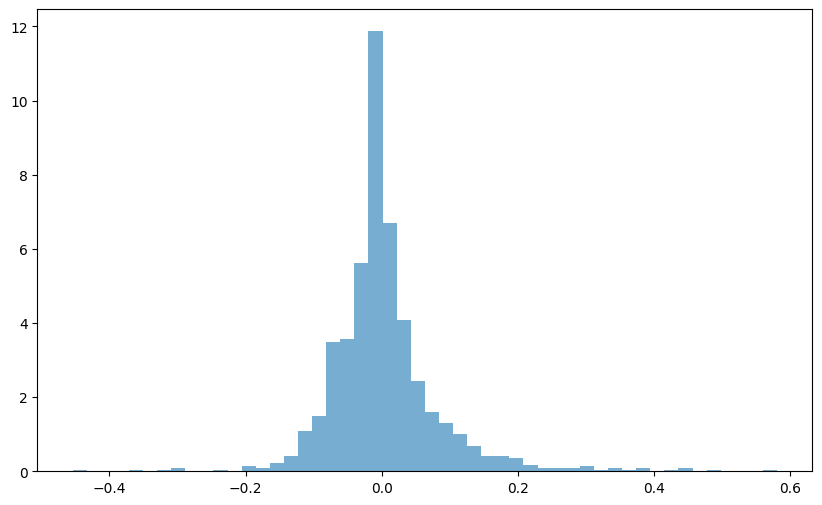

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(rgti_close['chg'], bins=50, density=True, alpha=0.6) # y-axis for ith value(heigth) = ith_bandwidth_count / (total_count * ith_bandwidth)  , nubmer of values in ith bandwidth = height×N×w=12×1000×0.01=120

In [ ]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes=True,
                    vertical_spacing=0.03,
                    subplot_titles=('Price', 'Volume'),
                    row_width=[0.2, 0.7])
fig.add_trace(go.Candlestick(x=rgti.index,
                            open=rgti['Open'],
                            high=rgti['High'],
                            low=rgti['Low'],
                            close=rgti['Close'],
                            increasing_line_color='red',
                            decreasing_line_color='blue'),
              row=1, col=1)
fig.add_trace(go.Bar(x=rgti.index, y=rgti['Volume'], showlegend=False),
              row=2, col=1)

fig.update_layout(
    title='RGTI Stock Price with Volume',
    yaxis_title='Price ($)',
    xaxis_rangeslider_visible=False,
)

fig.show()

#### Data Load, Check simply return variation

In [40]:
tickers = ['RGTI','QBTS','QUBT','IONQ', '^TNX','2YY=F','^IXIC','^RUT']
tgt_date = '2021-01-01' # 그래도 최소한 이 정도는 됐으면 좋겠다 싶은 날짜(물론 그 이후에 상장됐다면 유감)

histories = {
    t:yf.Ticker(t).history(period='max') for t in tickers
}

for t, _ in histories.items():
  histories[t]['ma10'] = histories[t]['Close'].rolling(window=10).mean()
  histories[t]['ma50'] = histories[t]['Close'].rolling(window=50).mean()
  histories[t]['std10'] = histories[t]['Close'].rolling(window=10).std()
  histories[t]['std50'] = histories[t]['Close'].rolling(window=50).std()
  histories[t]['prc_chg'] = (histories[t]['Close'] - histories[t]['Close'].shift(1)) / histories[t]['Close'].shift(1)
  histories[t]['ma10_chg'] = (histories[t]['ma10'] - histories[t]['ma10'].shift(1)) / histories[t]['ma10'].shift(1)
  histories[t]['ma50_chg'] = (histories[t]['ma50'] - histories[t]['ma50'].shift(1)) / histories[t]['ma50'].shift(1)
  histories[t]['std10_chg'] = (histories[t]['std10'] - histories[t]['std10'].shift(1)) / histories[t]['std10'].shift(1)
  histories[t]['std50_chg'] = (histories[t]['std50'] - histories[t]['std50'].shift(1)) / histories[t]['std50'].shift(1)

  histories[t]['vol_ma10'] = histories[t]['Volume'].rolling(window=10).mean()
  histories[t]['vol_ma50'] = histories[t]['Volume'].rolling(window=50).mean()
  histories[t]['vol_std10'] = histories[t]['Volume'].rolling(window=10).std()
  histories[t]['vol_std50'] = histories[t]['Volume'].rolling(window=50).std()
  histories[t]['vol_ma1_chg'] = (histories[t]['Volume'] - histories[t]['Volume'].shift(1)) / histories[t]['Volume'].shift(1)
  histories[t]['vol_ma10_chg'] = (histories[t]['vol_ma10'] - histories[t]['vol_ma10'].shift(1)) / histories[t]['vol_ma10'].shift(1)
  histories[t]['vol_ma50_chg'] = (histories[t]['vol_ma50'] - histories[t]['vol_ma50'].shift(1)) / histories[t]['vol_ma50'].shift(1)
  histories[t]['vol_std10_chg'] = (histories[t]['vol_std10'] - histories[t]['vol_std10'].shift(1)) / histories[t]['vol_std10'].shift(1)
  histories[t]['vol_std50_chg'] = (histories[t]['vol_std50'] - histories[t]['vol_std50'].shift(1)) / histories[t]['vol_std50'].shift(1)

  histories[t]['intra_std'] = (histories[t]['High'] - histories[t]['Low']) / histories[t]['Open']

In [41]:
first_dates = {
  t: df.index.min().strftime("%Y-%m-%d") for t, df in histories.items()
}

small_date = max([*first_dates.values(), tgt_date])
for t, df in histories.items():
  data = df.loc[small_date:]
  prc_up_series = data['prc_chg'] > 0
  df['prc_up'] = prc_up_series

In [42]:
# RGTI
rgti= histories["RGTI"].loc[small_date:]
rgti_2021_return = get_return(rgti[small_date:])
rgti_2022_return = get_return(rgti['2022-01-01':])
rgti_2023_return = get_return(rgti['2023-01-01':])
rgti_2024_return = get_return(rgti['2024-01-01':])
rgti_2025_return = get_return(rgti['2025-01-01':])

# QBTS
qbts= histories["QBTS"].loc[small_date:]
qbts_2021_return = get_return(qbts)
qbts_2022_return = get_return(qbts['2022-01-01':])
qbts_2023_return = get_return(qbts['2023-01-01':])
qbts_2024_return = get_return(qbts['2024-01-01':])
qbts_2025_return = get_return(qbts['2025-01-01':])

# QUBT
qubt= histories["QUBT"].loc[small_date:]
qubt_2021_return = get_return(qubt)
qubt_2022_return = get_return(qubt['2022-01-01':])
qubt_2023_return = get_return(qubt['2023-01-01':])
qubt_2024_return = get_return(qubt['2024-01-01':])
qubt_2025_return = get_return(qubt['2025-01-01':])

# IONQ
ionq= histories["IONQ"].loc[small_date:]
ionq_2021_return = get_return(ionq)
ionq_2022_return = get_return(ionq['2022-01-01':])
ionq_2023_return = get_return(ionq['2023-01-01':])
ionq_2024_return = get_return(ionq['2024-01-01':])
ionq_2025_return = get_return(ionq['2025-01-01':])

In [43]:
nasdaq = histories["^IXIC"].loc[small_date:]
nasdaq_2021_return = get_return(nasdaq[small_date:])
nasdaq_2022_return = get_return(nasdaq['2022-01-01':])
nasdaq_2023_return = get_return(nasdaq['2023-01-01':])
nasdaq_2024_return = get_return(nasdaq['2024-01-01':])
nasdaq_2025_return = get_return(nasdaq['2025-01-01':])

tnx = histories["^TNX"].loc[small_date:]
tnx_2021_return = get_return(tnx[small_date:])
tnx_2022_return    = get_return(tnx['2022-01-01':])
tnx_2023_return    = get_return(tnx['2023-01-01':])
tnx_2024_return    = get_return(tnx['2024-01-01':])
tnx_2025_return    = get_return(tnx['2025-01-01':])

yy2 = histories["2YY=F"].loc[small_date:]
yy2_2021_return = get_return(yy2[small_date:])
yy2_2022_return    = get_return(yy2['2022-01-01':])
yy2_2023_return    = get_return(yy2['2023-01-01':])
yy2_2024_return    = get_return(yy2['2024-01-01':])
yy2_2025_return    = get_return(yy2['2025-01-01':])

russel = histories["^RUT"].loc[small_date:]
russel_2021_return = get_return(russel[small_date:])
russel_2022_return = get_return(russel['2022-01-01':])
russel_2023_return = get_return(russel['2023-01-01':])
russel_2024_return = get_return(russel['2024-01-01':])
russel_2025_return = get_return(russel['2025-01-01':])

In [44]:
print(f"RGTI 2021년도 수익률 표준편차 : {rgti_2021_return.describe()['std'] * 100:.5f} %")
print(f"RGTI 2022년도 수익률 표준편차 : {rgti_2022_return.describe()['std'] * 100:.5f} %")
print(f"RGTI 2023년도 수익률 표준편차 : {rgti_2023_return.describe()['std'] * 100:.5f} %")
print(f"RGTI 2024년도 수익률 표준편차 : {rgti_2024_return.describe()['std'] * 100:.5f} %")
print(f"RGTI 2025년도 수익률 표준편차 : {rgti_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

print(f"QBTS 2021년도 수익률 표준편차 : {qbts_2021_return.describe()['std'] * 100:.5f} %")
print(f"QBTS 2022년도 수익률 표준편차 : {qbts_2022_return.describe()['std'] * 100:.5f} %")
print(f"QBTS 2023년도 수익률 표준편차 : {qbts_2023_return.describe()['std'] * 100:.5f} %")
print(f"QBTS 2024년도 수익률 표준편차 : {qbts_2024_return.describe()['std'] * 100:.5f} %")
print(f"QBTS 2025년도 수익률 표준편차 : {qbts_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

print(f"QUBT 2021년도 수익률 표준편차 : {qubt_2021_return.describe()['std'] * 100:.5f} %")
print(f"QUBT 2022년도 수익률 표준편차 : {qubt_2022_return.describe()['std'] * 100:.5f} %")
print(f"QUBT 2023년도 수익률 표준편차 : {qubt_2023_return.describe()['std'] * 100:.5f} %")
print(f"QUBT 2024년도 수익률 표준편차 : {qubt_2024_return.describe()['std'] * 100:.5f} %")
print(f"QUBT 2025년도 수익률 표준편차 : {qubt_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

print(f"IONQ 2021년도 수익률 표준편차 : {ionq_2021_return.describe()['std'] * 100:.5f} %")
print(f"IONQ 2022년도 수익률 표준편차 : {ionq_2022_return.describe()['std'] * 100:.5f} %")
print(f"IONQ 2023년도 수익률 표준편차 : {ionq_2023_return.describe()['std'] * 100:.5f} %")
print(f"IONQ 2024년도 수익률 표준편차 : {ionq_2024_return.describe()['std'] * 100:.5f} %")
print(f"IONQ 2025년도 수익률 표준편차 : {ionq_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

print(f"나스닥 2021년도 수익률 표준편차 : {nasdaq_2021_return.describe()['std'] * 100:.5f} %")
print(f"나스닥 2022년도 수익률 표준편차 : {nasdaq_2022_return.describe()['std'] * 100:.5f} %")
print(f"나스닥 2023년도 수익률 표준편차 : {nasdaq_2023_return.describe()['std'] * 100:.5f} %")
print(f"나스닥 2024년도 수익률 표준편차 : {nasdaq_2024_return.describe()['std'] * 100:.5f} %")
print(f"나스닥 2025년도 수익률 표준편차 : {nasdaq_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

# TNX (미국 10년물 금리)
print(f"TNX 2021년도 수익률 표준편차 : {tnx_2021_return.describe()['std'] * 100:.5f} %")
print(f"TNX 2022년도 수익률 표준편차 : {tnx_2022_return.describe()['std'] * 100:.5f} %")
print(f"TNX 2023년도 수익률 표준편차 : {tnx_2023_return.describe()['std'] * 100:.5f} %")
print(f"TNX 2024년도 수익률 표준편차 : {tnx_2024_return.describe()['std'] * 100:.5f} %")
print(f"TNX 2025년도 수익률 표준편차 : {tnx_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

# 2YY (미국 2년물 금리)
print(f"2YY 2021년도 수익률 표준편차 : {yy2_2021_return.describe()['std'] * 100:.5f} %")
print(f"2YY 2022년도 수익률 표준편차 : {yy2_2022_return.describe()['std'] * 100:.5f} %")
print(f"2YY 2023년도 수익률 표준편차 : {yy2_2023_return.describe()['std'] * 100:.5f} %")
print(f"2YY 2024년도 수익률 표준편차 : {yy2_2024_return.describe()['std'] * 100:.5f} %")
print(f"2YY 2025년도 수익률 표준편차 : {yy2_2025_return.describe()['std'] * 100:.5f} %")
print("\n --------------------------------------------------------------- \n")

# RUT (Russell 2000 지수)
print(f"RUT 2021년도 수익률 표준편차 : {russel_2021_return.describe()['std'] * 100:.5f} %")
print(f"RUT 2022년도 수익률 표준편차 : {russel_2022_return.describe()['std'] * 100:.5f} %")
print(f"RUT 2023년도 수익률 표준편차 : {russel_2023_return.describe()['std'] * 100:.5f} %")
print(f"RUT 2024년도 수익률 표준편차 : {russel_2024_return.describe()['std'] * 100:.5f} %")
print(f"RUT 2025년도 수익률 표준편차 : {russel_2025_return.describe()['std'] * 100:.5f} %")


RGTI 2021년도 수익률 표준편차 : 8.55420 %
RGTI 2022년도 수익률 표준편차 : 8.99371 %
RGTI 2023년도 수익률 표준편차 : 9.76132 %
RGTI 2024년도 수익률 표준편차 : 10.05167 %
RGTI 2025년도 수익률 표준편차 : 10.50399 %

 --------------------------------------------------------------- 

QBTS 2021년도 수익률 표준편차 : 8.80058 %
QBTS 2022년도 수익률 표준편차 : 9.26919 %
QBTS 2023년도 수익률 표준편차 : 10.42302 %
QBTS 2024년도 수익률 표준편차 : 9.66061 %
QBTS 2025년도 수익률 표준편차 : 10.48300 %

 --------------------------------------------------------------- 

QUBT 2021년도 수익률 표준편차 : 8.83411 %
QUBT 2022년도 수익률 표준편차 : 9.03470 %
QUBT 2023년도 수익률 표준편차 : 9.88728 %
QUBT 2024년도 수익률 표준편차 : 11.82823 %
QUBT 2025년도 수익률 표준편차 : 10.54375 %

 --------------------------------------------------------------- 

IONQ 2021년도 수익률 표준편차 : 6.52135 %
IONQ 2022년도 수익률 표준편차 : 6.37600 %
IONQ 2023년도 수익률 표준편차 : 6.48507 %
IONQ 2024년도 수익률 표준편차 : 6.86940 %
IONQ 2025년도 수익률 표준편차 : 8.09903 %

 --------------------------------------------------------------- 

나스닥 2021년도 수익률 표준편차 : 1.50173 %
나스닥 2022년도 수익률 표준편차 : 1.54099 

## Trading Signal

In [36]:
rgti.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'ma10', 'ma50', 'std10', 'std50', 'prc_chg', 'ma10_chg', 'ma50_chg',
       'std10_chg', 'std50_chg', 'vol_ma10', 'vol_ma50', 'vol_std10',
       'vol_std50', 'vol_ma1_chg', 'vol_ma10_chg', 'vol_ma50_chg',
       'vol_std10_chg', 'vol_std50_chg', 'intra_std', 'prc_up'],
      dtype='object')

#### Data Preperation

In [45]:
rgti_selected = rgti[['Close','prc_chg', 'ma10_chg', 'ma50_chg',
       'std10_chg', 'std50_chg', 'vol_ma1_chg', 'vol_ma10_chg', 'vol_ma50_chg',
       'vol_std10_chg', 'vol_std50_chg', 'intra_std', 'prc_up']]
nasdaq_selected = nasdaq[['Close','prc_chg', 'ma10_chg', 'ma50_chg',
       'std10_chg', 'std50_chg', 'vol_ma1_chg', 'vol_ma10_chg', 'vol_ma50_chg',
       'vol_std10_chg', 'vol_std50_chg', 'intra_std', 'prc_up']]
tnx_selected = tnx[['Close','prc_chg', 'ma10_chg', 'ma50_chg',
       'std10_chg', 'std50_chg', 'vol_ma1_chg', 'vol_ma10_chg', 'vol_ma50_chg',
       'vol_std10_chg', 'vol_std50_chg', 'intra_std', 'prc_up']]
yy2_selected = yy2[['Close','prc_chg', 'ma10_chg', 'ma50_chg',
       'std10_chg', 'std50_chg', 'vol_ma1_chg', 'vol_ma10_chg', 'vol_ma50_chg',
       'vol_std10_chg', 'vol_std50_chg', 'intra_std', 'prc_up']]

In [46]:
rgti_selected.loc['2025-06-01':]

,Close,prc_chg,ma10_chg,ma50_chg,std10_chg,std50_chg,vol_ma1_chg,vol_ma10_chg,vol_ma50_chg,vol_std10_chg,vol_std50_chg,intra_std,prc_up
Date,,,,,,,,,,,,,
2025-06-02 00:00:00-04:00,12.260000,0.012387,0.003196,0.006606,-0.026108,0.014019,-0.445955,-0.047594,-0.014926,0.090684,-0.000354,0.055198,True
2025-06-03 00:00:00-04:00,12.040000,-0.017945,-0.000078,0.005961,0.000687,0.010034,0.414364,-0.024239,-0.006919,0.030787,-0.001285,0.080350,False
2025-06-04 00:00:00-04:00,11.820000,-0.018272,-0.000777,0.004070,0.008249,0.009112,-0.301208,-0.085763,-0.007428,0.040316,0.002974,0.043317,False
2025-06-05 00:00:00-04:00,10.890000,-0.078680,-0.000544,0.002126,0.011027,0.001739,0.195529,-0.046709,-0.000442,0.029295,0.000221,0.093988,False
2025-06-06 00:00:00-04:00,11.280000,0.035813,-0.020078,0.004164,0.030829,0.001488,0.084264,-0.197770,-0.001543,-0.430457,0.000450,0.069073,True
2025-06-09 00:00:00-04:00,11.320000,0.003546,-0.021442,0.005627,-0.044478,-0.004351,0.134095,-0.125394,0.006322,-0.418577,-0.003079,0.061707,True
2025-06-10 00:00:00-04:00,11.240000,-0.007067,-0.023941,0.006067,-0.142164,-0.009484,0.414337,-0.035360,0.014406,-0.253233,-0.001354,0.090199,False
2025-06-11 00:00:00-04:00,12.520000,0.113879,-0.013636,0.008977,-0.303566,-0.002030,1.904991,0.289065,0.061123,3.171045,0.164401,0.139459,True
2025-06-12 00:00:00-04:00,12.100000,-0.033546,-0.008851,0.008298,-0.223411,-0.011052,-0.475115,0.082298,0.025112,0.031758,0.011600,0.101903,False


#### Trial 1 : Use of price change and volume change, and std-deviation of the change

In [11]:
for row in rgti_selected.loc['2025-06-01':].itertuples(index=True, name='Row'):
  if (row.prc_chg > row.ma10_chg) and (row.vol_std10_chg > row.vol_std50_chg):
    print(f"{row.Index.date()} 에 매수")

2025-06-02 에 매수
2025-06-11 에 매수
2025-06-24 에 매수
2025-06-30 에 매수
2025-07-02 에 매수
2025-07-14 에 매수
2025-07-16 에 매수
2025-07-17 에 매수


#### Trial 2 : Bollinger Band + Volume break-through (good for short term : one day, one week)

In [12]:
rgti_selected_ = rgti_selected.copy()
nasdaq_selected_ = nasdaq_selected.copy()

# 일단은 10일 누적 가격 변화율과 10일 이평선 가격의 표준편차에 대한 볼린저 밴드
m = 1.5
rgti_selected_['prc_bb_up'] = rgti_selected_['ma10_chg'] + m*rgti_selected_['ma10_chg']
rgti_selected_['prc_bb_down'] = rgti_selected_['ma10_chg'] - m*rgti_selected_['ma10_chg']

rgti_selected_['std_bb_up'] = rgti_selected_['std10_chg'] + m*rgti_selected_['std10_chg']
rgti_selected_['std_bb_down'] = rgti_selected_['std10_chg'] - m*rgti_selected_['std10_chg']

nasdaq_selected_['prc_bb_up'] = nasdaq_selected_['ma10_chg'] + m*nasdaq_selected_['ma10_chg']
nasdaq_selected_['prc_bb_down'] = nasdaq_selected_['ma10_chg'] - m*nasdaq_selected_['ma10_chg']

nasdaq_selected_['std_bb_up'] = nasdaq_selected_['std10_chg'] + m*nasdaq_selected_['std10_chg']
nasdaq_selected_['std_bb_down'] = nasdaq_selected_['std10_chg'] - m*nasdaq_selected_['std10_chg']

In [13]:
df_sig = rgti_selected_.copy()

# buy signal at time t
df_sig['buy_sig']  = (
    (df_sig['prc_chg'] >= df_sig['prc_bb_up']) &
    (df_sig['vol_ma1_chg'] > df_sig['vol_ma10_chg']) &
    (df_sig['vol_std10_chg'] > df_sig['vol_std50_chg'])
) | (df_sig['vol_ma1_chg'] > df_sig['vol_ma10_chg'])

# sell signal at time j
df_sig['sell_sig'] = (
    (df_sig['prc_chg'] < df_sig['prc_bb_down']) &
    (df_sig['intra_std'] > 0.05)
)

# since we want to determine whether sell or buy at time t+1, shift buy_sig at t toward t+1(at index t when buy_sig is True, then it means we should buy at t+1, since buy_sig is a signal we should buy next trading session)
df_sig['buy_sig_next']  = df_sig['buy_sig'].shift(1).fillna(False)
df_sig['sell_sig_next'] = df_sig['sell_sig'].shift(1).fillna(False)

/tmp/ipython-input-2190967001.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sig['buy_sig_next']  = df_sig['buy_sig'].shift(1).fillna(False)
/tmp/ipython-input-2190967001.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sig['sell_sig_next'] = df_sig['sell_sig'].shift(1).fillna(False)


In [39]:
new_df, return_ = backtest_signals(df_sig)
print(f"누적 매매 수익률 : {return_ * 100:.2f}%")
new_df['2025-06-01':]

누적 매매 수익률 : -43.03%


,Close,prc_chg,ma10_chg,ma50_chg,std10_chg,std50_chg,vol_ma1_chg,vol_ma10_chg,vol_ma50_chg,vol_std10_chg,...,prc_bb_down,std_bb_up,std_bb_down,buy_sig,sell_sig,buy_sig_next,sell_sig_next,position,entry_price,exit_price
Date,,,,,,,,,,,,,,,,,,,,,
2025-06-02 00:00:00-04:00,12.260000,0.012387,0.003196,0.006606,-0.026108,0.014019,-0.445955,-0.047594,-0.014926,0.090684,...,-0.001598,-0.065270,0.013054,False,False,True,True,1,12.26,NaN
2025-06-03 00:00:00-04:00,12.040000,-0.017945,-0.000078,0.005961,0.000687,0.010034,0.414364,-0.024239,-0.006919,0.030787,...,0.000039,0.001719,-0.000344,True,True,False,False,1,NaN,NaN
2025-06-04 00:00:00-04:00,11.820000,-0.018272,-0.000777,0.004070,0.008249,0.009112,-0.301208,-0.085763,-0.007428,0.040316,...,0.000389,0.020622,-0.004124,False,False,True,True,0,NaN,11.82
2025-06-05 00:00:00-04:00,10.890000,-0.078680,-0.000544,0.002126,0.011027,0.001739,0.195529,-0.046709,-0.000442,0.029295,...,0.000272,0.027568,-0.005514,True,True,False,False,0,NaN,NaN
2025-06-06 00:00:00-04:00,11.280000,0.035813,-0.020078,0.004164,0.030829,0.001488,0.084264,-0.197770,-0.001543,-0.430457,...,0.010039,0.077072,-0.015414,True,False,True,True,1,11.28,NaN
2025-06-09 00:00:00-04:00,11.320000,0.003546,-0.021442,0.005627,-0.044478,-0.004351,0.134095,-0.125394,0.006322,-0.418577,...,0.010721,-0.111194,0.022239,True,True,True,False,1,NaN,NaN
2025-06-10 00:00:00-04:00,11.240000,-0.007067,-0.023941,0.006067,-0.142164,-0.009484,0.414337,-0.035360,0.014406,-0.253233,...,0.011970,-0.355411,0.071082,True,True,True,True,0,NaN,11.24
2025-06-11 00:00:00-04:00,12.520000,0.113879,-0.013636,0.008977,-0.303566,-0.002030,1.904991,0.289065,0.061123,3.171045,...,0.006818,-0.758915,0.151783,True,False,True,True,1,12.52,NaN
2025-06-12 00:00:00-04:00,12.100000,-0.033546,-0.008851,0.008298,-0.223411,-0.011052,-0.475115,0.082298,0.025112,0.031758,...,0.004426,-0.558529,0.111706,False,True,True,False,1,NaN,NaN


#### Trial 3 : price up and down forecast/classification :  then we would reinforce the strategy by utilize DNN(maybe)  

In [47]:
rgti_selected_ = rgti_selected.copy()
nasdaq_selected_ = nasdaq_selected.copy()

In [48]:
rgti_selected_

,Close,prc_chg,ma10_chg,ma50_chg,std10_chg,std50_chg,vol_ma1_chg,vol_ma10_chg,vol_ma50_chg,vol_std10_chg,vol_std50_chg,intra_std,prc_up
Date,,,,,,,,,,,,,
2021-08-13 00:00:00-04:00,9.705,-0.002569,-0.000052,-0.000215,-0.012184,-0.007272,33.839506,1.624642,0.146037,3.271340,0.102422,0.005670,False
2021-08-16 00:00:00-04:00,9.700,-0.000515,-0.000206,-0.000328,-0.076595,-0.050394,-0.751595,0.157478,-0.062201,0.001444,-0.042569,0.007246,False
2021-08-17 00:00:00-04:00,9.680,-0.002062,-0.000103,-0.000246,0.044095,0.005777,-0.644793,-0.055647,0.010741,0.001547,-0.002148,0.005171,False
2021-08-18 00:00:00-04:00,9.690,0.001033,0.000000,-0.000174,0.000000,0.008804,-0.871486,-0.010237,-0.001048,0.002045,0.000286,0.008307,True
2021-08-19 00:00:00-04:00,9.690,0.000000,-0.000206,-0.000226,-0.031505,-0.004903,-0.906250,0.000252,-0.003482,-0.000057,0.000954,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-24 00:00:00-04:00,15.950,-0.011772,0.019570,0.006974,-0.047582,0.031969,0.056415,0.016318,-0.018295,-0.009793,-0.002789,0.030960,False
2025-07-25 00:00:00-04:00,15.440,-0.031975,0.021429,0.008775,-0.169532,-0.003900,-0.386590,-0.016164,-0.018563,0.011636,0.006200,0.042033,False
2025-07-28 00:00:00-04:00,15.570,0.008420,0.018019,0.006132,-0.207786,0.018703,0.560969,0.012589,-0.035596,-0.007617,-0.038477,0.069798,True


In [ ]:
df_sig = rgti_selected_.copy()

# t 시점의 시그널
df_sig['buy_sig']  = (
    (df_sig['prc_chg'] >= df_sig['prc_bb_up']) &
    (df_sig['vol_ma1_chg'] > df_sig['vol_ma10_chg']) &
    (df_sig['vol_std10_chg'] > df_sig['vol_std50_chg'])
) | (df_sig['vol_ma1_chg'] > df_sig['vol_ma10_chg'])

df_sig['sell_sig'] = (
    (df_sig['prc_chg'] < df_sig['prc_bb_down']) &
    (df_sig['intra_std'] > 0.05)
)

# t+1 시그널 실행용으로 shift
df_sig['buy_sig_next']  = df_sig['buy_sig'].shift(1).fillna(False)
df_sig['sell_sig_next'] = df_sig['sell_sig'].shift(1).fillna(False)